Simple Kalman filter demo
=========================

In this demo, we'll build a Kalman filter using the ForneyLab toolbox. The goal is to filter noisy scalar observations.

Let `xin` be the (unknown) state of the system, `xout` the next state, `u` the system input and `y` the noisy observation of `xin`:

\begin{align*}
    x_{out} &= x_{in} + u\\
    y &= x_{in} + n\\
    u &= u_{const}\\
    n &\sim \mathcal{N}(0, V_{noise})\,.
\end{align*}

For simplicity, we assume that `u` is a constant: `u_const`. We further assume that the observations are corrupted by white Gaussian noise, with variance `V_noise`. 

The Kalman filter can be represented as a Forney-style factor graph:

```
                   (u)
            (equ)   |
    (xin) --> = --> + --> (xout)
              |    (add_u_xin)
       (n)--> +(add_n_y)
              |
             (y)
```

The complete Kalman filter is obtained by chaining multiple of these sections, connecting `xout` of the previous stage to `xin` of the next stage. 

Let's start by importing ForneyLab, defining the constants and creating the nodes:

In [1]:
using ForneyLab

# Settings
V_noise = 200.0 # variance of the noise (n)
u_const = 1.0   # fixed value for u

# Create nodes
xin         = PriorNode(name="xin")
xout        = TerminalNode(name="xout")
n           = TerminalNode(GaussianDistribution(m=0.0, V=V_noise), name="n")
y           = TerminalNode(name="y")
add_n_y     = AdditionNode(name="add_n_y")
equ         = EqualityNode(name="equ")
add_u_xin   = AdditionNode(name="add_u_xin")
u           = TerminalNode(DeltaDistribution(u_const), name="u");

As you can see, we create terminal and prior nodes for the nodes that hold known values or distributions. We can pass the value of a `TerminalNode` to the constructor, as we do for the `n` and `u` nodes. These nodes will always send out a message with this payload. The `GaussianDistribution` is defined by its mean vector (`m`) and covariance matrix (`V`). The message of the `u` node has zero variance since we have no uncertainty about its value. Further, we have 2 addition nodes and 1 equality constraint node with 3 interfaces.

Now let's connect the nodes by defining the edges, and define a time wrap to connect the sections:

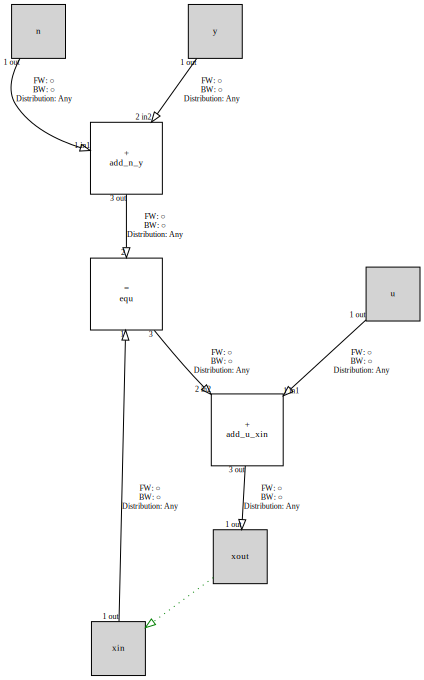

In [2]:
# Create edges
Edge(xin, equ.i[1])
Edge(n, add_n_y.i[:in1])
Edge(y, add_n_y.i[:in2])
Edge(add_n_y.i[:out], equ.i[2])
Edge(equ.i[3], add_u_xin.i[:in2])
Edge(u, add_u_xin.i[:in1])
Edge(add_u_xin.i[:out], xout)

# Define time wrap
wrap(xout, xin); # Feed posterior estimate to prior

# Inspect the graph
draw()

Now that the factor graph is complete, we can set the initial message, create the message passing schedule, and create a buffer to hold the results. In addition to the write buffer, which was introduced in the previous demo, we also define a read buffer that reads an input value on each call to `step()`.

In [3]:
# Set initiatal value of xin to get started
xin.value = GaussianDistribution(m=1.0+randn()*sqrt(V_noise), V=V_noise)

# Data
n_samples = 100
noisy_y = [i+randn()*sqrt(V_noise) for i=1:n_samples] # Generate noisy observations of y
y_buffer = [DeltaDistribution(noisy_y[i]) for i=1:n_samples]
setReadBuffer(y, y_buffer) # TerminalNode y will take value y_buffer[n] in timestep n

# Create output buffer to record the values we wish to observe in every timestep
state = setWriteBuffer(add_u_xin.i[:out])

# Declare the inference procedure
algo = SumProduct.Algorithm()

show(algo.fields[:schedule])

Message passing schedule (entry: node [interface], rule)


------------------------------------------------------
1: TerminalNode u [1:out], sumProduct! 
2: TerminalNode xin [1:out], sumProduct! 
3: TerminalNode n [1:out], sumProduct! 
4: TerminalNode y [1:out], sumProduct! 
5: AdditionNode add_n_y [3:out], sumProduct! 
6: EqualityNode equ [3:], sumProduct! 
7: AdditionNode add_u_xin [3:out], sumProduct! 


All set. Now we apply the filter by calculating the message towards `xout`. Then, we move this message to `xin` and repeat the process 100 times. This way, we simulate a forward pass over 100 sections.

In [4]:
# Do forward passes
run(algo)

That was easy!
Let's plot the filter output (mean and standard deviation of `xout`) together with the noisy observations to see if it worked.

INFO: Loading help data...


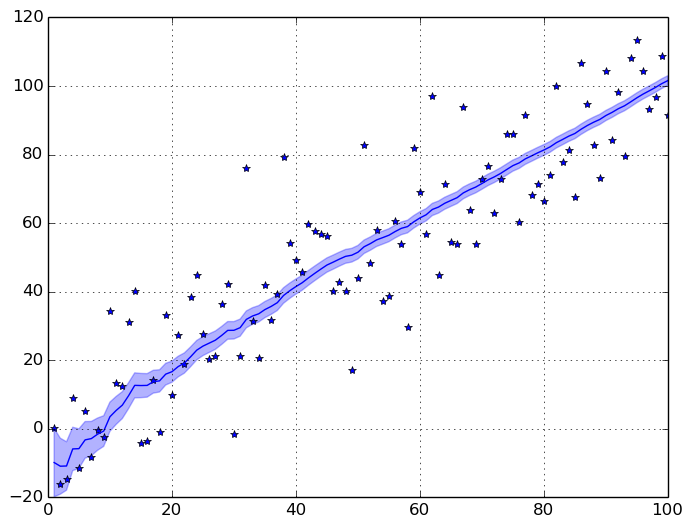

In [5]:
using PyPlot
results_mean = Float64[mean(s)[1] for s in state]
results_variance = Float64[var(s)[1,1] for s in state]
plot([1:n_samples], noisy_y, "b*")
plot([1:n_samples], results_mean, "b-")
fill_between([1:n_samples], results_mean-sqrt(results_variance), results_mean+sqrt(results_variance), color="b", alpha=0.3);
grid(true)